# OC model error analysis

Olatomiwa O. Bifarin

## Table of Contents
<a id="0"></a>
- [The Datasets](#1) <br>
- [ML Performance](#2) <br>
- [Confusion Matrix](#3)<br>
- [SHAP Analysis](#4)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import sklearn
import autosklearn
import shap
import openpyxl
import PipelineProfiler

#To ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# numpy random seed.
np.random.seed(42)

## The Dataset
<a id="1"></a>

**Load and transform metabolomic dataset**

In [3]:
train_cohort = pd.read_excel('data/17lipid_balanced_train.xlsx')

In [4]:
#drop the unnamed column from the dataframe
train_cohort.drop("Unnamed: 0", 
                  axis=1, 
                  inplace=True)

In [5]:
train_cohort.head();

In [6]:
# Separate target and features
target = "class" # Replace with your target column name.
X_train = train_cohort.drop(target, axis=1)

#Skip autoscaling it appears the dataset has already being scaled.
#X_train =(X_train - X_train.mean(axis=0))/X_train.std(axis=0) #autoscaling
y_train = train_cohort[target]

In [7]:
print(f"There are {y_train.tolist().count(0)} Non OC samples") 
print(f"There are {y_train.tolist().count(1)} OC samples")

There are 144 Non OC samples
There are 144 OC samples


In [8]:
X_train.head();

**Load test set**

In [9]:
test_cohort = pd.read_excel('data/test_set_17lipid.xlsx')

In [10]:
test_cohort.head();

In [11]:
#drop class and the unnamed column
X_test = test_cohort.drop(["Unnamed: 0", target], 
                          axis=1)
# data appears to be scaled
#X_test =(X_test - X_test.mean(axis=0))/X_test.std(axis=0) #autoscaling
y_test = test_cohort[target]

In [12]:
y_test.value_counts()

class
1    64
0    34
Name: count, dtype: int64

### [table of contents](#0)

## ML performance
<a id="2"></a>

In [13]:
import pickle

model_filename = 'askl_17_OC_3600.pkl'

# Load the model from the file
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [14]:
from sklearn.metrics import confusion_matrix

estimator_askl = loaded_model

# ROC score
prediction = estimator_askl.predict_proba(X_test)
roc_askl = roc_auc_score(y_test, prediction[:, 1])
print("AutoML ROC-AUC test set: %0.2f" %(roc_askl))

# Accuracy
y_pred = estimator_askl.predict(X_test)
#acc_askl = accuracy_score(y_test, y_pred)
#print("AutoML Accuracy test set: %0.2f" %(acc_askl))

# Confusion matrix
print(f"AutoML confusion matrix: {confusion_matrix(y_test, y_pred)}")

AutoML ROC-AUC test set: 0.85
AutoML confusion matrix: [[28  6]
 [16 48]]


### [table of contents](#0)

## Confusion Matrix
<a id="3"></a>

In [15]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[28,  6],
       [16, 48]])

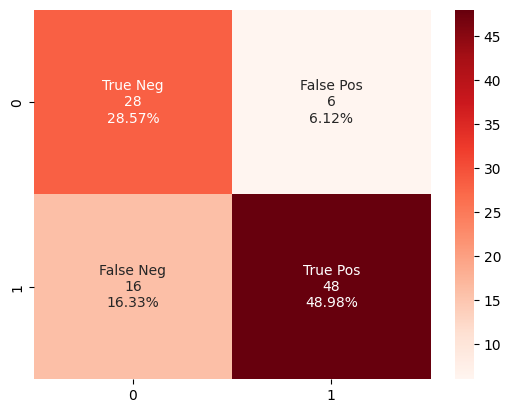

In [16]:
# Plot confusion matrix.

import seaborn as sns

group_names = ["True Neg","False Pos","False Neg","True Pos"]

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Reds'); #Blues

In [17]:
# merging predicted samples with ground truth. 
list_of_tuples = list(zip(y_pred, y_test))
error_list = pd.DataFrame(list_of_tuples, 
                  columns = ['Prediction', 'Label'])
error_list.head()

,Prediction,Label
0,0,1
1,1,1
2,0,1
3,1,1
4,0,1


`0` is non-OC samples while `1` is OC samples. 

**True Positive Samples: OC samples classified as a OC**

In [18]:
# True positive
tp = error_list.loc[(error_list['Prediction'] == 1) & (error_list['Label'] == 1)]
tp.head(4)

,Prediction,Label
1,1,1
3,1,1
5,1,1
7,1,1


In [19]:
# get the index as a list
tp_list = tp.index.tolist()

print(f"Theere are {len(tp_list)} true positives, and these are their indices: {tp_list}.")

Theere are 48 true positives, and these are their indices: [1, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61].


**False Negative Samples: OC samples classified as non-OC samples**

In [20]:
# False Negative
fn = error_list.loc[(error_list['Prediction'] == 0) & (error_list['Label'] == 1)]
fn.head(4)

,Prediction,Label
0,0,1
2,0,1
4,0,1
6,0,1


In [21]:
# get the index as a list
fn_list = fn.index.tolist()

print(f"There are {len(fn_list)} false negatives, and these are their indices: {fn_list}.")

There are 16 false negatives, and these are their indices: [0, 2, 4, 6, 8, 16, 28, 29, 32, 36, 43, 48, 49, 60, 62, 63].


**True Negative Samples: non-OC samples classified as non-OC samples**

In [22]:
# True negative
tn = error_list.loc[(error_list['Prediction'] == 0) & (error_list['Label'] == 0)]
tn.head(4)

,Prediction,Label
64,0,0
65,0,0
66,0,0
67,0,0


In [23]:
# get the index as a list
tn_list = tn.index.tolist()

print(f"There are {len(tn_list)} true negatives, and these are their indices: {tn_list}.")

There are 28 true negatives, and these are their indices: [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 90, 92, 95, 96, 97].


**False Positive Samples: non-OC samples classified as OC samples**

In [24]:
# False positive
fp = error_list.loc[(error_list['Prediction'] == 1) & (error_list['Label'] == 0)]
fp.head(4)

,Prediction,Label
74,1,0
84,1,0
86,1,0
91,1,0


In [25]:
# get the index as a list
fp_list = fp.index.tolist()

print(f"Theere are {len(fp_list)} false positive, and these are their indices: {fp_list}.")

Theere are 6 false positive, and these are their indices: [74, 84, 86, 91, 93, 94].


### [table of contents](#0)

## SHAP Analysis
<a id="4"></a>

In [26]:
import shap
shap.initjs()

# Create a wrapper function for estimator_askl.predict_proba 
# that converts NumPy arrays back to pandas DataFrames:
def predict_proba_wrapper(X):
    X_df = pd.DataFrame(X, columns=X_train.columns)
    return estimator_askl.predict_proba(X_df)

In [27]:
#estimator_askl.predict_proba or just use the wrapper.

X_train_summary = shap.kmeans(X_train.values, 10)
# Model baseline: Use X_train_summary to summarize the training set or use whole train data.
explainer = shap.KernelExplainer(predict_proba_wrapper, X_train_summary, 
                                 link='identity', seed=42) #'logit?'

shap_values = explainer.shap_values(X_test.values, seed=42) #X_trainDF, X_testDF

  0%|          | 0/98 [00:00<?, ?it/s]

In [28]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[1].shape}')

length of SHAP values: 2
Shape of each element: (98, 17)


***Update name for columns.***

In [29]:
# Dictionary mapping old column names to new column names
rename_dict = {
    'feat134LPC(14:0)>LPC(14:0/0:0)_and_LPC(0:0/14:0)_P135': 'LPC(14:0)',
    'feat331PC(O-36:5)_P332': 'PC(O-36:5)',
    'feat32Cer(d34:1)>Cer(d18:1/16:0)_P33': 'Cer(d18:1_16:0)',
    'feat58Cer(d43:2)>Cer(d18:1/25:1)_P59': 'Cer(d18:1_25:1)',
    'feat931PC(O-40:7)>PC(O-18:1/22:6)_and_PC(O-22:7/18:0) M + CH3COOH': 'PC(40:7)',
    'feat426PS(38:4)>PS(18:0_20:4)_P427': 'PS(18:0_20:4)',
    'feat401PE(O-40:5)>PE(O-18:1/22:4)_P402': 'PE(O-18:1_22:4)',
    'feat390PE(O-38:4)_P391': 'PE(O-38:4)',
    'feat307PC(O-32:2)_P308': 'PC(O-32:2)',
    'feat46Cer(d41:2)>Cer(d18:2/23:0)_P47': 'Cer(d18:2_23:0)',
    'GM3(18:0/24:2)': 'GM3(18:0_24:2)',
    'GM3(18:1/24:0))': 'GM3(18:1_24:0)',
    'GM1(18:1/16:0)': 'GM1(18:1_16:0)',
    '3794 GM3(d34:1)': 'GM3(d34:1)',
    'GM3(18:1/16:0)': 'GM3(18:1_16:0)',
    'GM3(18:1/12:0) No MS2': 'GM3(18:1_12:0)',
    'GM3(18:1/22:1) no MS2': 'GM3(18:1_22:1)'
}

# Rename columns
X_test.rename(columns=rename_dict, inplace=True)

In [30]:
X_test.head()

,LPC(14:0),PC(O-36:5),Cer(d18:1_16:0),Cer(d18:1_25:1),PC(40:7),PS(18:0_20:4),PE(O-18:1_22:4),PE(O-38:4),PC(O-32:2),Cer(d18:2_23:0),GM3(18:0_24:2),GM3(18:1_24:0),GM1(18:1_16:0),GM3(d34:1),GM3(18:1_16:0),GM3(18:1_12:0),GM3(18:1_22:1)
0,-0.221834,-0.076163,1.126763,0.369878,-1.233505,-0.939914,1.038515,-0.258966,1.095117,2.090807,0.596740,0.690509,0.379919,-3.330352,0.110242,-0.186368,0.318752
1,-0.760862,-0.728632,1.100585,2.082330,0.232730,0.098545,-1.226714,-0.811655,-1.030403,2.562752,0.015627,-0.324790,0.014585,0.965318,1.437911,-0.569695,0.664050
2,0.679680,-0.112154,-0.643243,0.138469,1.028122,-0.186218,-0.412658,0.143682,-0.806736,0.262022,1.182795,1.288461,-0.460872,2.651003,0.777726,-0.007381,2.244034
3,-0.507703,-0.557451,-0.515512,-0.779160,-0.711659,-0.537556,-0.927823,-0.745030,-0.825748,-1.082778,-0.377360,-0.095379,0.250676,1.503571,-0.775004,-0.305169,-0.650783
4,-0.604466,3.626587,-0.192819,-1.187932,0.822954,3.029852,-1.970146,1.367202,1.449710,-0.997569,-0.175814,-0.734604,0.170439,-0.666990,-0.658656,-0.129271,-0.988756


**SHAP decision plot for all samples**

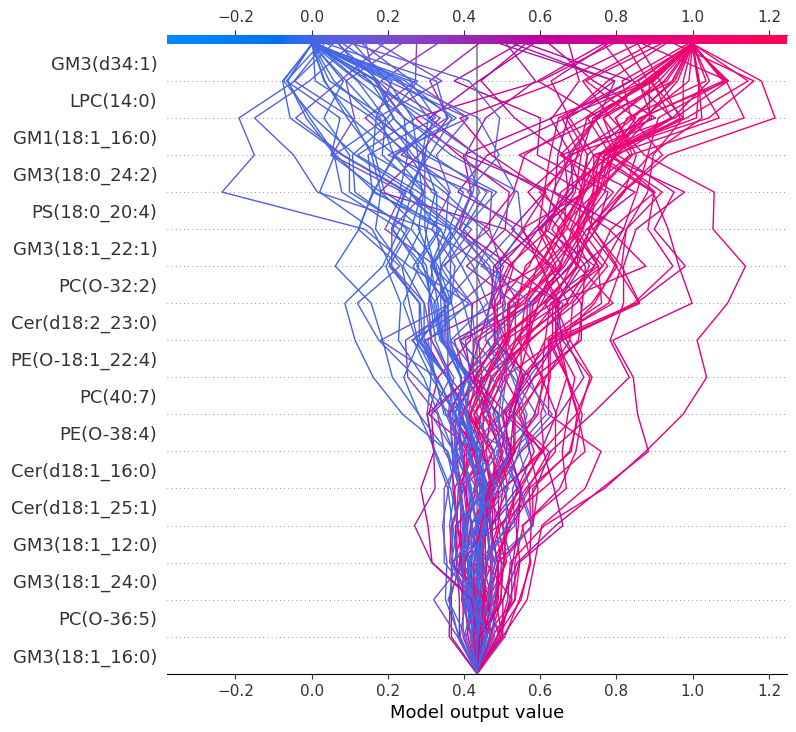

In [31]:
# create a shap decision plot
shap.decision_plot(explainer.expected_value[1], 
                   shap_values[1], 
                   feature_names=list(X_test.columns), 
                   link='identity')

**True positive _vs_ False negatives**

*True Positive*

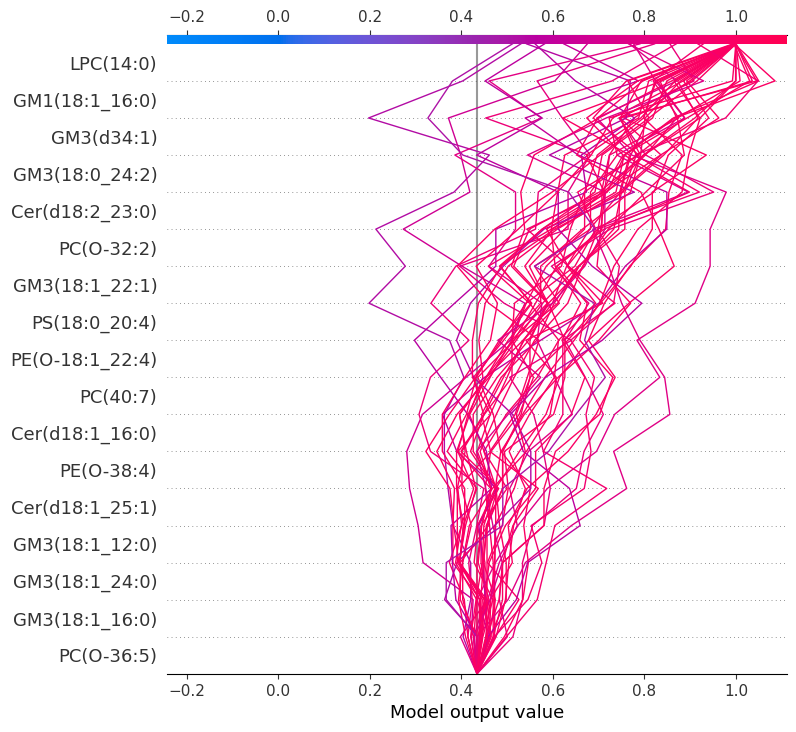

In [54]:
import matplotlib.pyplot as plt
# True Positives
tp_shap_values = np.array([shap_values[1][i] for i in tp_list])
tp_X_test = X_test.iloc[tp_list]

shap.decision_plot(explainer.expected_value[1], tp_shap_values, 
                   tp_X_test, link='identity', show=False)

# Save the plot
#plt.savefig("OC_Decision_plot_TP.svg")
#plt.clf()

plt.show()

*False Negative*

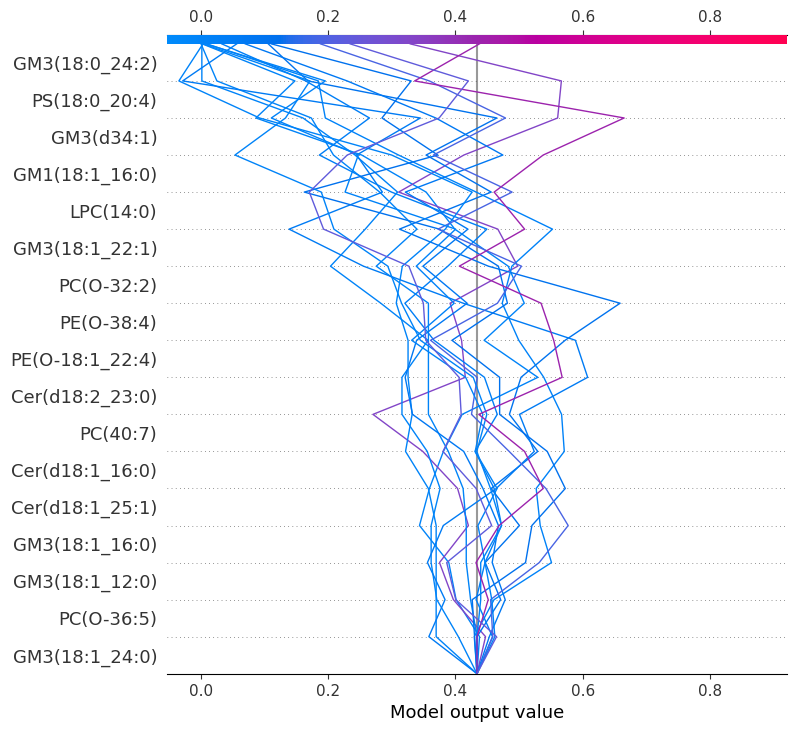

In [56]:
# False Negatives
fn_shap_values = np.array([shap_values[1][i] for i in fn_list])
fn_X_test = X_test.iloc[fn_list]

shap.decision_plot(explainer.expected_value[1], fn_shap_values, 
                   fn_X_test, link='identity', show=False)

# Save the plot
#plt.savefig("OC_Decision_plot_FN.svg")
#plt.clf()

plt.show()

In [34]:
def feature_order(X_test, shap_values):
    # Get feature names
    feature_names = X_test.columns

    # Compute the sum of absolute SHAP values for each feature
    sum_abs_shap_values = np.sum(np.abs(shap_values), axis=0)

    # Create a DataFrame for easy manipulation
    df = pd.DataFrame(list(zip(feature_names, sum_abs_shap_values)), columns=['feature', 'sum_abs_shap_values'])

    # Sort the DataFrame by the sum of absolute SHAP values in descending order
    df = df.sort_values(by='sum_abs_shap_values', ascending=False)

    # Return the ordered features
    return df['feature']

Kendall's Tau: 0.6617647058823529
P-value: 8.216178860308908e-05


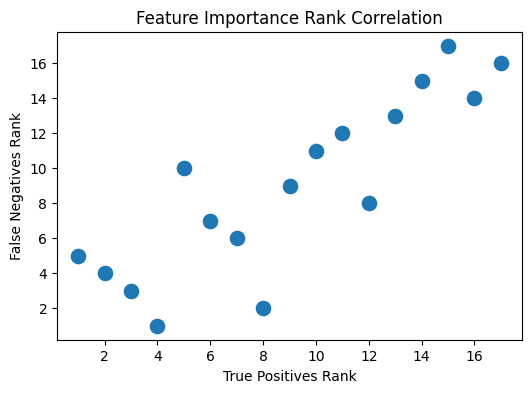

In [58]:
from scipy.stats import kendalltau
import seaborn as sns

# Get ordered features for true positives and false negatives
tp_ordered_features = feature_order(tp_X_test, tp_shap_values)
fn_ordered_features = feature_order(fn_X_test, fn_shap_values)

# Convert to ranks
tp_ranks = pd.Series(range(1, len(tp_ordered_features) + 1), index=tp_ordered_features)
fn_ranks = pd.Series(range(1, len(fn_ordered_features) + 1), index=fn_ordered_features)

# Align the two series on feature names
aligned_tp_ranks, aligned_fn_ranks = tp_ranks.align(fn_ranks, join='inner')

# Compute Kendall's Tau and p-value
tau, p_value = kendalltau(aligned_tp_ranks, aligned_fn_ranks)

# Print Kendall's Tau and p-value
print("Kendall's Tau:", tau)
print("P-value:", p_value)

# Plot a scatter plot of the ranks
plt.figure(figsize=(6, 4))
sns.scatterplot(x=aligned_tp_ranks, y=aligned_fn_ranks, s=150)
plt.xlabel('True Positives Rank')
plt.ylabel('False Negatives Rank')
plt.title('Feature Importance Rank Correlation')

# Save the plot
#plt.savefig("FNvsTP_correlation.svg")
#plt.clf()

plt.show()

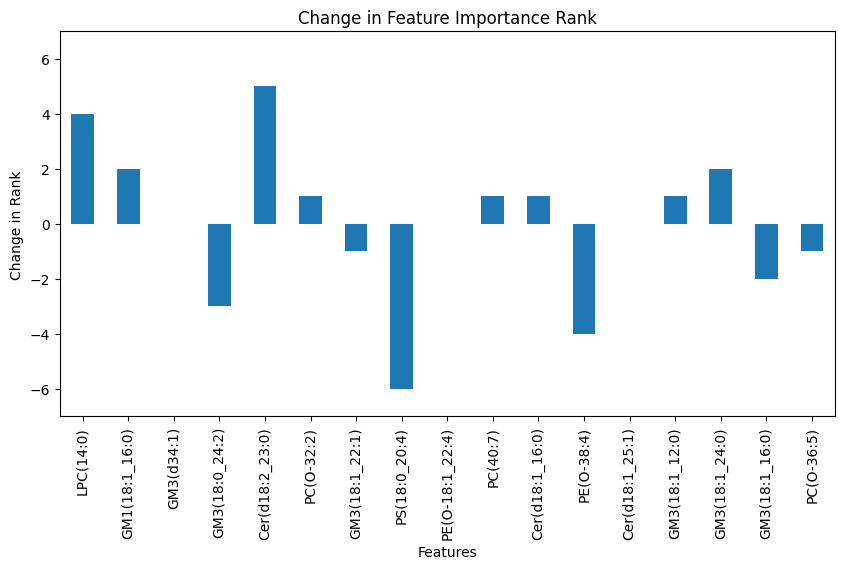

In [64]:
# Assuming you have two ordered feature lists: tp_ordered_features and fn_ordered_features

# Convert to ranks
tp_ranks = pd.Series(range(1, len(tp_ordered_features) + 1), index=tp_ordered_features)
fn_ranks = pd.Series(range(1, len(fn_ordered_features) + 1), index=fn_ordered_features)

# Align the two series on feature names
aligned_tp_ranks, aligned_fn_ranks = tp_ranks.align(fn_ranks, join='inner')

# Compute the change in ranks
rank_change = aligned_fn_ranks - aligned_tp_ranks

# Plot a bar chart of the rank changes
plt.figure(figsize=(10, 5))

rank_change.plot(kind='bar')
plt.ylim(-7, 7)
plt.xlabel('Features')
plt.ylabel('Change in Rank')
plt.title('Change in Feature Importance Rank')

# Save the plot
#plt.savefig("FNvsTP_change_in_rank.svg")
plt.show()

**True negative _vs_ False positives**

*True Negative*

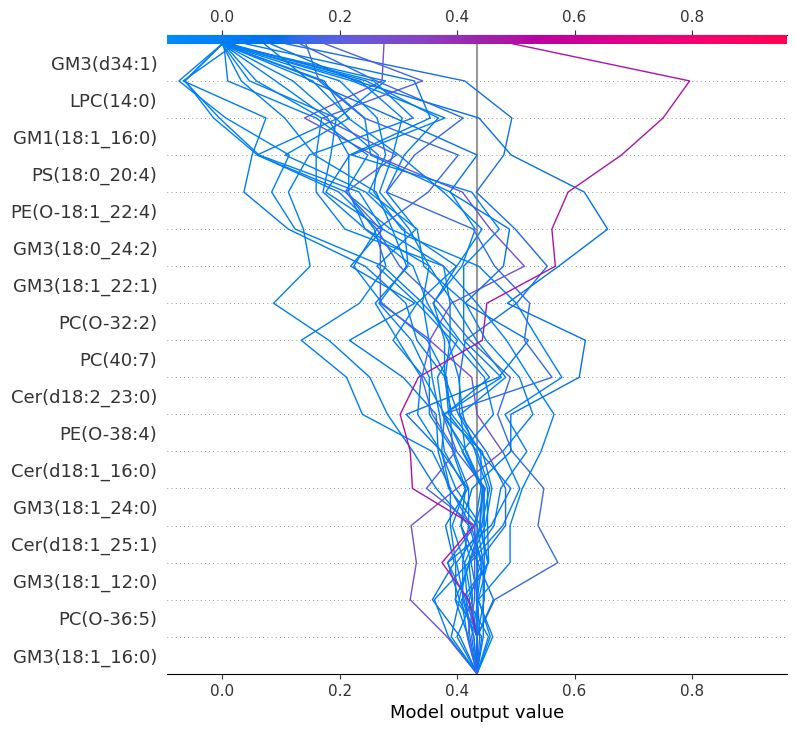

In [65]:
# True Negatives
tn_shap_values = np.array([shap_values[1][i] for i in tn_list])
tn_X_test = X_test.iloc[tn_list]

shap.decision_plot(explainer.expected_value[1], tn_shap_values, 
                   tn_X_test, link='identity', show=False)

# Save the plot
#plt.savefig("Decision_plot_TN.svg")
#plt.clf()
plt.show()

*False Positive*

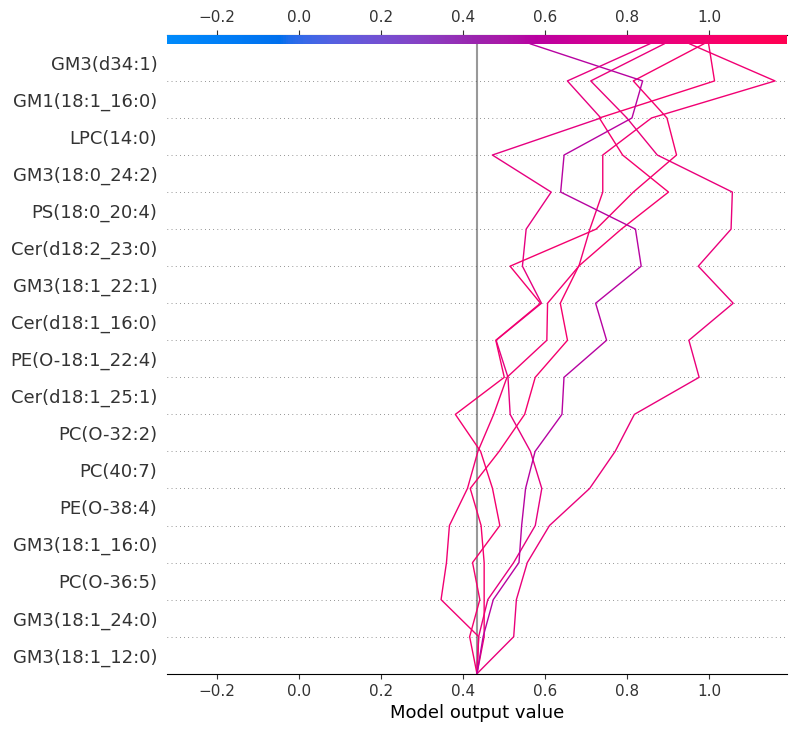

In [66]:
# False Positive
fp_shap_values = np.array([shap_values[1][i] for i in fp_list])
fp_X_test = X_test.iloc[fp_list]

shap.decision_plot(explainer.expected_value[1], fp_shap_values, 
                   fp_X_test, link='identity', show=False)

# Save the plot
#plt.savefig("Decision_plot_FP.svg")
#plt.clf()
plt.show()

Kendall's Tau: 0.6911764705882353
P-value: 3.209019424470449e-05


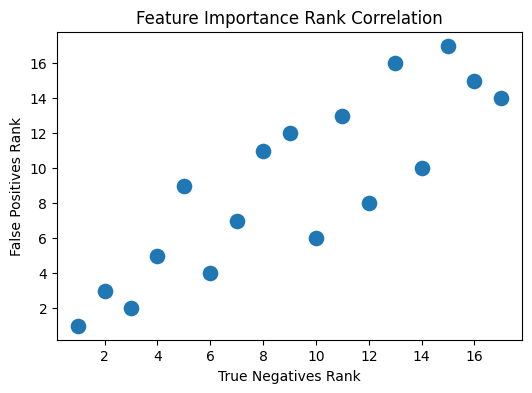

In [67]:
# Get ordered features for true positives and false negatives
tn_ordered_features = feature_order(tn_X_test, tn_shap_values)
fp_ordered_features = feature_order(fp_X_test, fp_shap_values)

# Convert to ranks
tn_ranks = pd.Series(range(1, len(tn_ordered_features) + 1), index=tn_ordered_features)
fp_ranks = pd.Series(range(1, len(fp_ordered_features) + 1), index=fp_ordered_features)

# Align the two series on feature names
aligned_tn_ranks, aligned_fp_ranks = tn_ranks.align(fp_ranks, join='inner')

# Compute Kendall's Tau and p-value
tau, p_value = kendalltau(aligned_tn_ranks, aligned_fp_ranks)

# Print Kendall's Tau and p-value
print("Kendall's Tau:", tau)
print("P-value:", p_value)

# Plot a scatter plot of the ranks
plt.figure(figsize=(6, 4))
sns.scatterplot(x=aligned_tn_ranks, y=aligned_fp_ranks, s=150)
plt.xlabel('True Negatives Rank')
plt.ylabel('False Positives Rank')
plt.title('Feature Importance Rank Correlation')

# Save the plot
#plt.savefig("TNvsFP_correlation.svg")
#plt.clf()
plt.show()

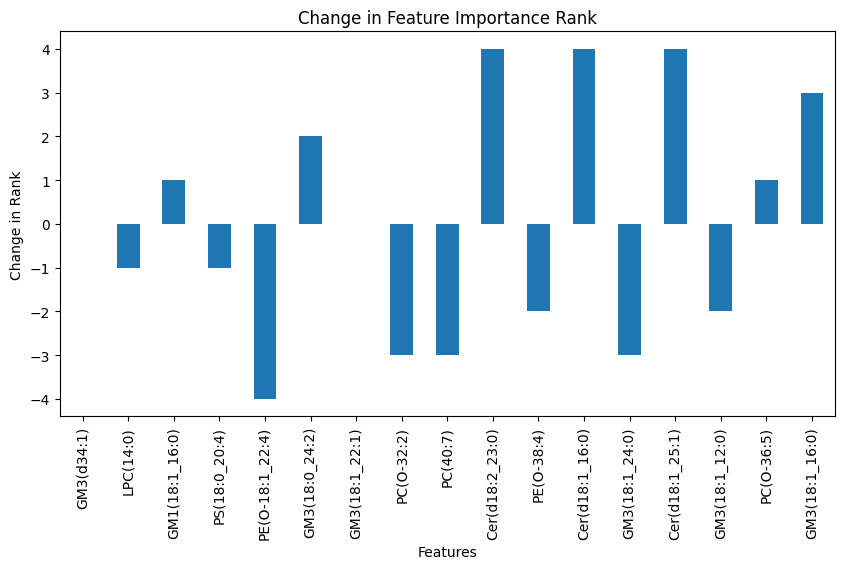

In [68]:
# Convert to ranks
tn_ranks = pd.Series(range(1, len(tn_ordered_features) + 1), index=tn_ordered_features)
fp_ranks = pd.Series(range(1, len(fp_ordered_features) + 1), index=fp_ordered_features)

# Align the two series on feature names
aligned_tn_ranks, aligned_fp_ranks = tn_ranks.align(fp_ranks, join='inner')

# Compute the change in ranks
rank_change = aligned_tn_ranks - aligned_fp_ranks

# Plot a bar chart of the rank changes
plt.figure(figsize=(10, 5))
rank_change.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Change in Rank')
plt.title('Change in Feature Importance Rank')

# Save the plot
#plt.savefig("TNvsFP_change_in_rank.svg")
plt.show()

**Typical prediction path**

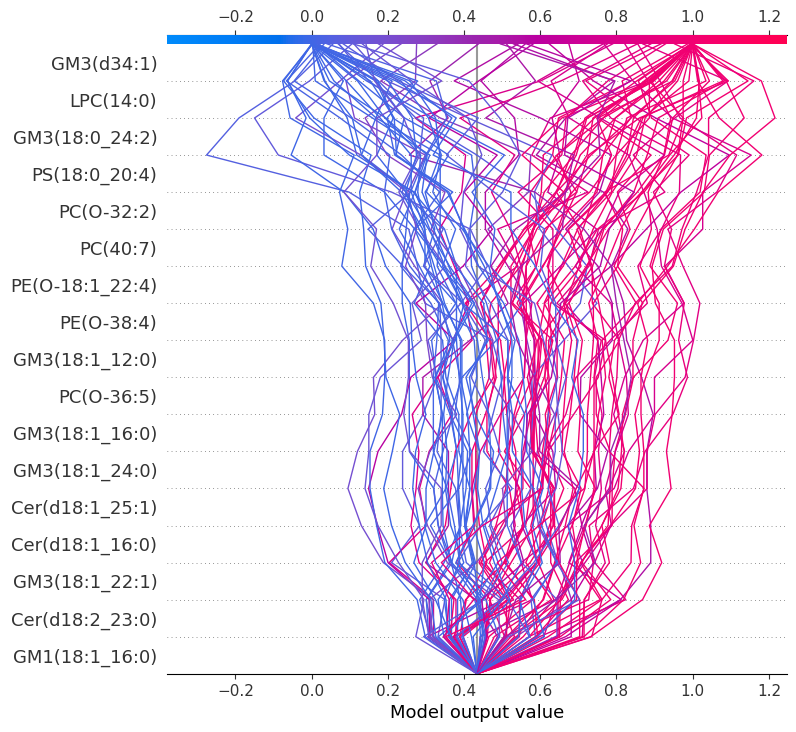

In [41]:
# create a shap decision plot
shap.decision_plot(explainer.expected_value[1], 
                   shap_values[1], 
                   feature_names=list(X_test.columns), 
                   link='identity', 
                   feature_order='hclust')  # use 'hclust' in feature_order